In [ ]:
# Import Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [8]:
#Load Datasets

train=pd.read_csv('/content/train.csv').tail(1000000)
test=pd.read_csv('/content/test.csv')
holidays=pd.read_csv('/content/holidays_events.csv')
oil=pd.read_csv('/content/oil.csv')
stores=pd.read_csv('/content/stores.csv')
transactions=pd.read_csv('/content/transactions.csv')


In [10]:
# Convert date columns to datetime format
train["date"] = pd.to_datetime(train["date"])
test["date"] = pd.to_datetime(test["date"])
oil["date"] = pd.to_datetime(oil["date"])
holidays["date"] = pd.to_datetime(holidays["date"])

In [11]:
df_prophet= train.filter(['date','sales'])

In [12]:
# Handle missing values in oil prices using interpolation
oil["dcoilwtico"] = oil["dcoilwtico"].interpolate()

In [13]:
# Merge additional datasets with train and test data
train = train.merge(stores, on="store_nbr", how="left")
train = train.merge(oil, on="date", how="left")
train = train.merge(holidays, on="date", how="left")

test = test.merge(stores, on="store_nbr", how="left")
test = test.merge(oil, on="date", how="left")
test = test.merge(holidays, on="date", how="left")

In [ ]:
train['sales'].describe()

,sales
count,2.297640e+06
mean,3.232560e+02
std,1.019646e+03
min,0.000000e+00
25%,0.000000e+00
50%,7.000000e+00
75%,1.741972e+02
max,1.247170e+05


In [15]:
## Time-based Features
train["day"] = train["date"].dt.day
train["week"] = train["date"].dt.isocalendar().week
train["month"] = train["date"].dt.month
train["year"] = train["date"].dt.year
train["day_of_week"] = train["date"].dt.dayofweek
train["is_december"] = (train["month"] == 12).astype(int)

test["day"] = test["date"].dt.day
test["week"] = test["date"].dt.isocalendar().week
test["month"] = test["date"].dt.month
test["year"] = test["date"].dt.year
test["day_of_week"] = test["date"].dt.dayofweek
test["is_december"] = (test["month"] == 12).astype(int)

In [16]:
## Event-based Features
train["is_holiday"] = train["type_y"].notnull().astype(int)
test["is_holiday"] = test["type_y"].notnull().astype(int)

train["is_payday"] = ((train["day"] == 15) | (train["day"] == train["date"].dt.days_in_month)).astype(int)
test["is_payday"] = ((test["day"] == 15) | (test["day"] == test["date"].dt.days_in_month)).astype(int)

train["earthquake_impact"] = (train["date"] == "2016-04-16").astype(int)
test["earthquake_impact"] = (test["date"] == "2016-04-16").astype(int)

In [17]:
## Rolling Statistics
train.sort_values(by=["store_nbr", "family", "date"], inplace=True)
test.sort_values(by=["store_nbr", "family", "date"], inplace=True)

train["sales_7d_avg"] = train.groupby(["store_nbr", "family"])['sales'].transform(lambda x: x.rolling(7, min_periods=1).mean())
train["sales_7d_std"] = train.groupby(["store_nbr", "family"])['sales'].transform(lambda x: x.rolling(7, min_periods=1).std())
train["sales_lag_7"] = train.groupby(["store_nbr", "family"])['sales'].shift(7)
train["sales_lag_30"] = train.groupby(["store_nbr", "family"])['sales'].shift(30)

In [18]:
## Store-Specific Aggregations
store_avg_sales = train.groupby("store_nbr")["sales"].mean().rename("store_avg_sales")
train = train.merge(store_avg_sales, on="store_nbr", how="left")
test = test.merge(store_avg_sales, on="store_nbr", how="left")

top_selling_families = train.groupby("family")["sales"].sum().sort_values(ascending=False).head(10).index
train["is_top_family"] = train["family"].isin(top_selling_families).astype(int)
test["is_top_family"] = test["family"].isin(top_selling_families).astype(int)

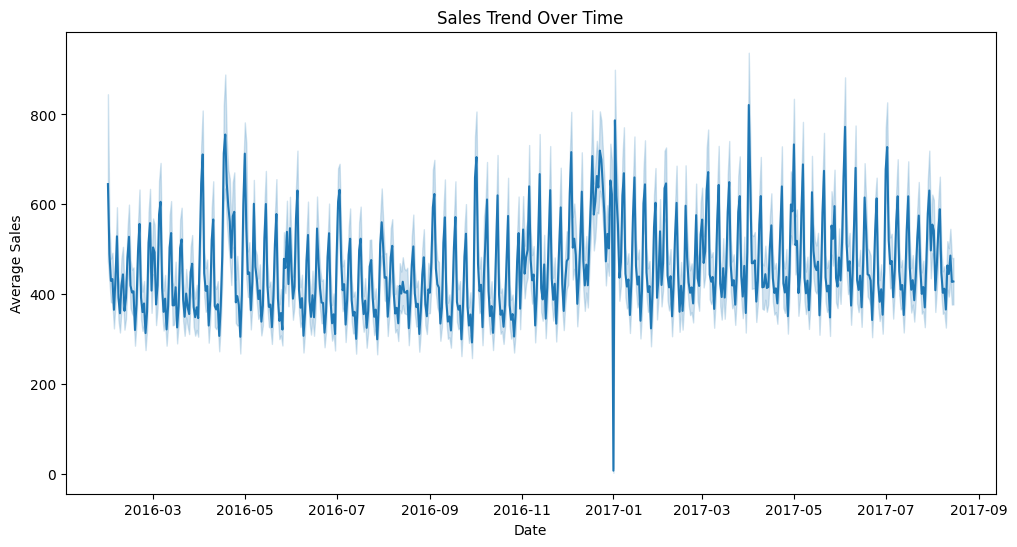

In [19]:
## Visualizing sales trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=train, x="date", y="sales", estimator="mean")
plt.title("Sales Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Average Sales")
plt.show()

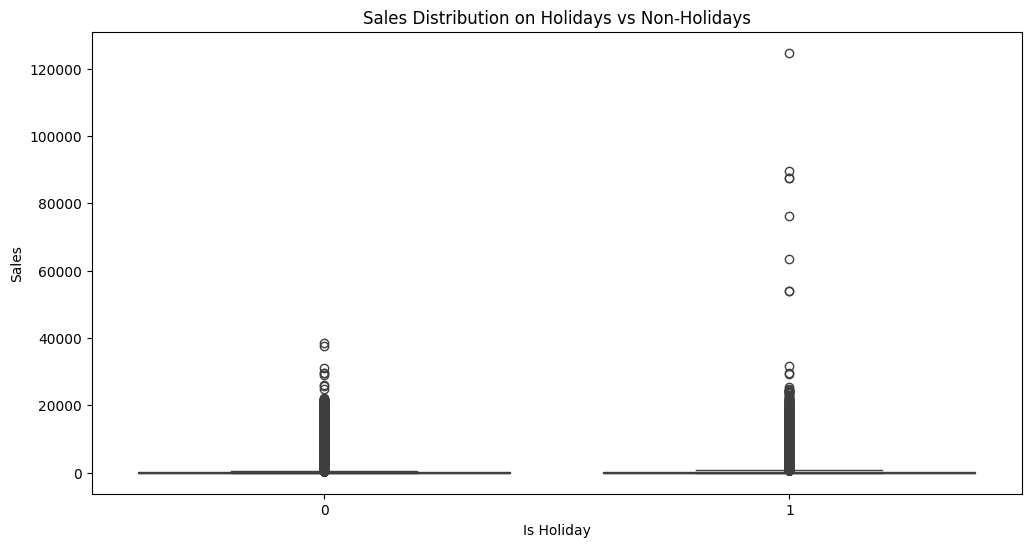

In [20]:
## Sales before and after holidays and promotions
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, x="is_holiday", y="sales")
plt.title("Sales Distribution on Holidays vs Non-Holidays")
plt.xlabel("Is Holiday")
plt.ylabel("Sales")
plt.show()

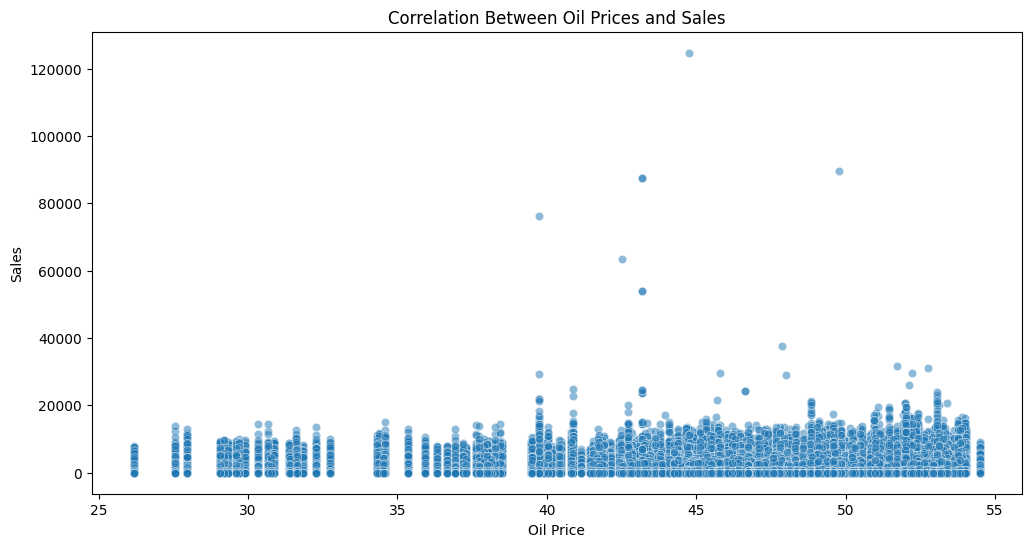

In [21]:
## Correlation between oil prices and sales trends
plt.figure(figsize=(12, 6))
sns.scatterplot(data=train, x="dcoilwtico", y="sales", alpha=0.5)
plt.title("Correlation Between Oil Prices and Sales")
plt.xlabel("Oil Price")
plt.ylabel("Sales")
plt.show()

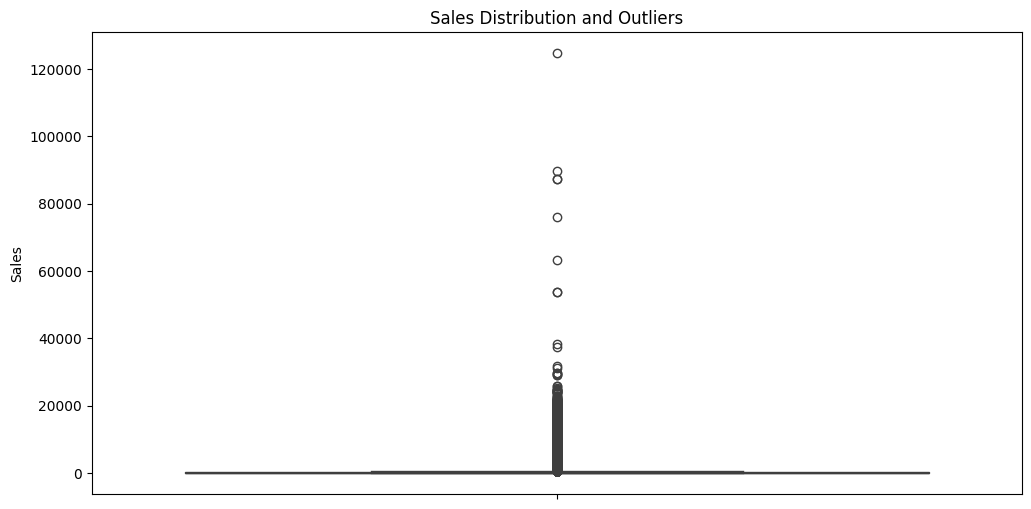

In [22]:
## Identifying anomalies in sales data
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, y="sales")
plt.title("Sales Distribution and Outliers")
plt.ylabel("Sales")
plt.show()

In [ ]:
# Features and their importance:

# Time-based Features Day, Week, Month, Year, Day of the Week-Helps capture seasonality and cyclical trends.

# Some products may have higher sales on weekends or specific months (e.g., December for holiday shopping).

# Weekly and monthly trends assist in detecting recurring patterns.

# Event-based Features is_holiday (Binary flag for holidays)
    # Captures holiday sales spikes or dips.

    # Useful for models to anticipate sales surges before public holidays.

# is_promotion (Binary flag for promotions)

    # Helps models factor in promotional discounts or campaigns affecting demand.

# is_payday (Flag for the 15th and last day of the month)

    # Many employees receive salaries on these dates, impacting consumer spending.

# earthquake_impact (Flag for April 16, 2016 earthquake)

    # Accounts for potential anomalies in sales due to natural disasters.

# Rolling Statistics Moving Averages (sales_ma7, sales_ma30)
  # Smooths out short-term fluctuations and highlights longer-term trends.

# Weekly (7-day) and monthly (30-day) averages help predict short-term demand.

# Rolling Standard Deviations (sales_std7, sales_std30)

    # Measures sales volatility, which can indicate product stability.

    # Helps adjust predictions for more stable vs. highly variable products.

# Lagged Features (sales_lag7, sales_lag30)

    # Uses past sales data (1 week & 1 month ago) to predict future demand.

    # Essential for time-series forecasting as past patterns often repeat.



In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [24]:
## Encode categorical features
label_encoders = {}
categorical_columns = ["family", "city", "state", "type_x","type_y",]
for col in categorical_columns:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

In [25]:
## Drop unnecessary columns
train.drop(columns=["date","id","locale","locale_name","description","transferred"], inplace=True)
test.drop(columns=["date","locale","locale_name","description","transferred"], inplace=True)

In [26]:
# Filling NA values with 0.
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [27]:
## Splitting train data into training and validation sets
X = train.drop(columns=["sales"])
y = train["sales"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

In [29]:
# Define evaluation function
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}")
    print(f"R2 Score: {r2}\n")
    return rmse, mape, r2

In [30]:
### Baseline Model (Naïve Forecasting) ###
# Ensure y_val and y_train have matching indices
y_pred_naive = np.roll(y_train, shift=1)[-len(y_test):]  # Shift last values forward
y_pred_naive[0] = y_train.iloc[-1]  # Use last known sales value for first prediction

# Evaluate model
rmse_naive, mape_naive, r2_naive = evaluate_model(y_test, y_pred_naive, "Naïve Forecasting")

Naïve Forecasting Performance:
RMSE: 1870.6910707895859
MAPE: 3.594846030207147e+17
R2 Score: -0.9853702207914541



In [31]:
from statsmodels.tsa.arima.model import ARIMA

In [32]:
### ARIMA Model ###
model_arima = ARIMA(y_train, order=(2,1,0))
model_arima_fit = model_arima.fit()
y_pred_arima = model_arima_fit.forecast(steps=len(y_test))
rmse_arima, mape_arima, r2_arima = evaluate_model(y_test, y_pred_arima, "ARIMA")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

ARIMA Performance:
RMSE: 1441.0005282420086
MAPE: 7.831135377887636e+17
R2 Score: -0.17805519011024895



In [100]:
sales_prediction_arima = model_arima_fit.forecast(steps=len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [102]:
test['sales']=sales_prediction_arima.values

In [103]:
test[['id', 'sales']].to_csv('submission_arima.csv', index=False)

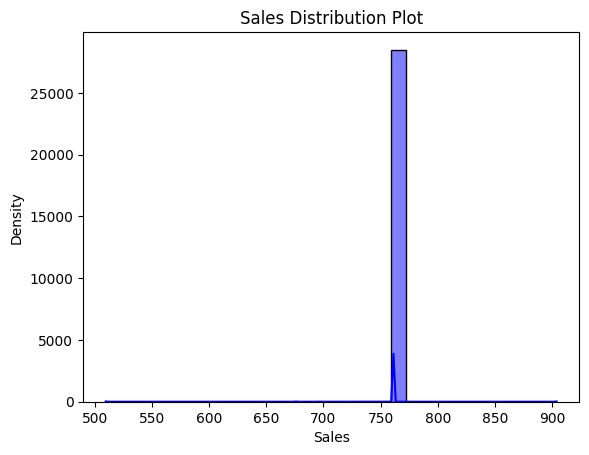

In [68]:
# Plot distribution
sns.histplot(prediction_arima['sales'], kde=True, bins=30, color="blue")

# Labels and title
plt.xlabel("Sales")
plt.ylabel("Density")
plt.title("Sales Distribution Plot")

# Show the plot
plt.show()

In [38]:
from sklearn.ensemble import RandomForestRegressor

In [39]:
# ### Random Forest Regressor ###
rf_model = RandomForestRegressor(n_estimators=1, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rmse_rf, mape_rf, r2_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")

Random Forest Performance:
RMSE: 400.02825432287966
MAPE: 1303293780556290.2
R2 Score: 0.9092140398744413



In [40]:
from xgboost import XGBRegressor

In [41]:
### XGBoost Model ###
xgb_model = XGBRegressor(n_estimators=50, learning_rate=0.1, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb, mape_xgb, r2_xgb = evaluate_model(y_test, y_pred_xgb, "XGBoost")

XGBoost Performance:
RMSE: 317.30673106649436
MAPE: 7759913645306295.0
R2 Score: 0.9428789835700164



In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [43]:
### LSTM Model ###

y_train = np.array(y_train)
y_test = np.array(y_test)

# Reshape to 2D for MinMaxScaler
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

# Reshape for LSTM input (samples, time steps, features)
X_train_lstm = np.reshape(y_train_scaled, (y_train_scaled.shape[0], 1, 1))
X_test_lstm = np.reshape(y_test_scaled, (y_test_scaled.shape[0], 1, 1))

# LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1,1)),
    Dropout(0.2),
    LSTM(50),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
lstm_model.fit(X_train_lstm, y_train_scaled, epochs=5, batch_size=512, verbose=1)

# Predict and inverse transform
y_pred_lstm = scaler.inverse_transform(lstm_model.predict(X_test_lstm))

# Evaluate Model (Ensure evaluate_model is defined)
rmse_lstm, mape_lstm, r2_lstm = evaluate_model(y_test, y_pred_lstm, "LSTM")

Epoch 1/5
1605/1605 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 2.8051e-05
Epoch 2/5
1605/1605 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 6.9677e-07
Epoch 3/5
1605/1605 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 6.6461e-07
Epoch 4/5
1605/1605 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 6.8480e-07
Epoch 5/5
1605/1605 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 6.5495e-07
6418/6418 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
LSTM Performance:
RMSE: 27.90522531610174
MAPE: 2.1892924569538908e+16
R2 Score: 0.999558217586006



In [44]:
import prophet

In [45]:
# Prophet Model
prophet_df = df_prophet[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})
prophet_model = prophet.Prophet()
prophet_model.fit(prophet_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29o4egr3/htnrs2gv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29o4egr3/vo5b01a2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13298', 'data', 'file=/tmp/tmp29o4egr3/htnrs2gv.json', 'init=/tmp/tmp29o4egr3/vo5b01a2.json', 'output', 'file=/tmp/tmp29o4egr3/prophet_modeljf4r8hiy/prophet_model-20250323075055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:50:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:52:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [63]:
future_pred = prophet_model.make_future_dataframe(periods=10000, freq='D')
forecast_pred = prophet_model.predict(future)
y_testpred_prophet = forecast_pred['yhat'].iloc[-10000:].values

In [64]:
rmse_prophet, mape_prophet, r2_prophet = evaluate_model(y_test[-10000:], y_testpred_prophet, "Prophet Model")

Prophet Model Performance:
RMSE: 3221.0761720181536
MAPE: 1.9023172525588613e+18
R2 Score: -5.109749748792283



In [47]:
future = prophet_model.make_future_dataframe(periods=len(test), freq='D')
forecast = prophet_model.predict(future)
y_pred_prophet = forecast['yhat'].iloc[-len(test):].values

In [51]:
# Save predictions using Prophet Model
test['sales'] = y_pred_prophet
test[['id', 'sales']].to_csv('submission_prophet.csv', index=False)

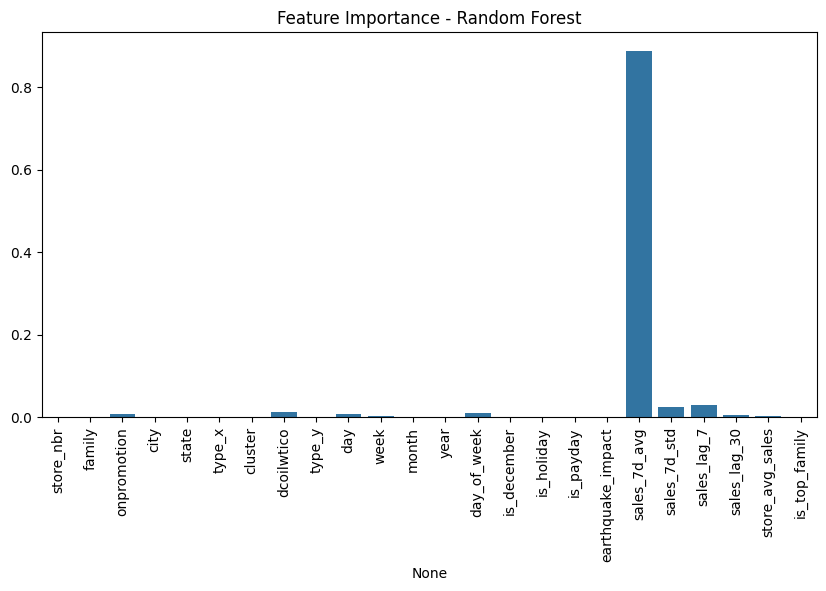

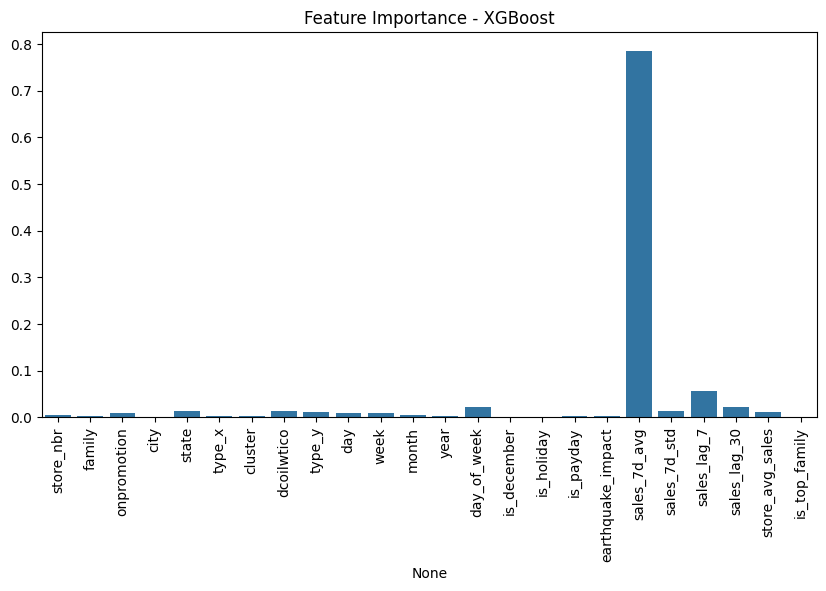

In [52]:
# Feature Importance (Random Forest & XGBoost)
plt.figure(figsize=(10,5))
sns.barplot(x=X_train.columns, y=rf_model.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature Importance - Random Forest")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x=X_train.columns, y=xgb_model.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature Importance - XGBoost")
plt.show()

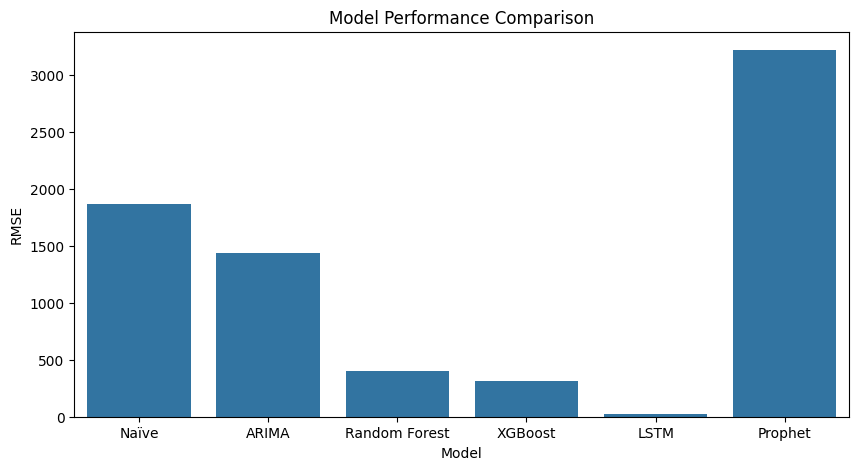

In [65]:
# Comparing Models
models = ["Naïve", "ARIMA", "Random Forest", "XGBoost", "LSTM","Prophet"]
rmse_values = [rmse_naive, rmse_arima, rmse_rf, rmse_xgb, rmse_lstm,rmse_prophet]

plt.figure(figsize=(10,5))
sns.barplot(x=models, y=rmse_values)
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("Model Performance Comparison")
plt.show()

In [ ]:
# Based on the value of RMSE LSTM model is the most accurate among the six model used here.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


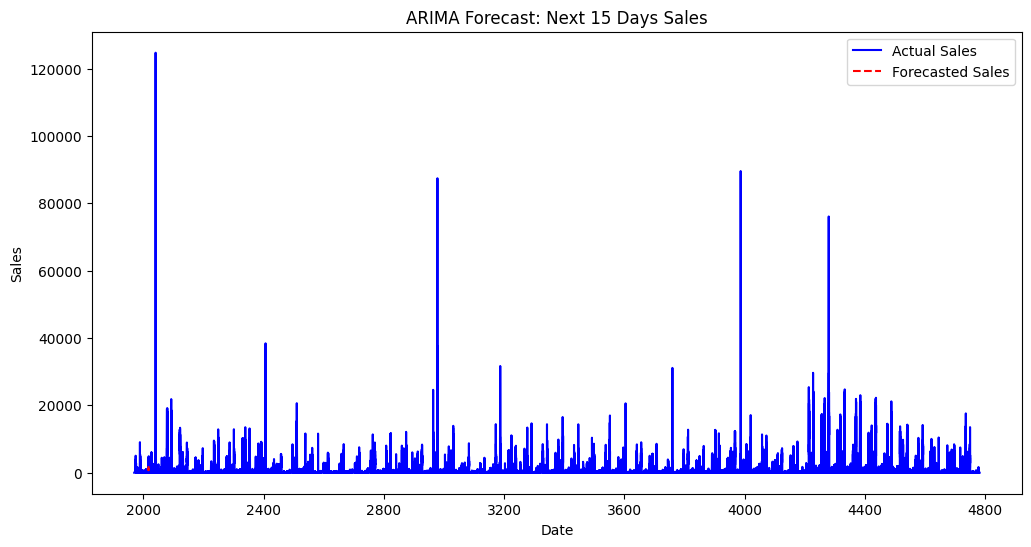

             date  predicted_sales
821384 2017-08-16      1947.572486
821385 2017-08-17       740.984209
821386 2017-08-18       906.226621
821387 2017-08-19      1198.556534
821388 2017-08-20       948.600894
821389 2017-08-21      1017.688295
821390 2017-08-22      1055.015555
821391 2017-08-23      1007.092425
821392 2017-08-24      1026.582519
821393 2017-08-25      1029.577377
821394 2017-08-26      1021.080274
821395 2017-08-27      1025.744649
821396 2017-08-28      1025.470095
821397 2017-08-29      1024.097258
821398 2017-08-30      1025.103834


In [109]:
# Forecast next 15 days
forecast_steps = 15
future_dates = pd.date_range(start=prophet_df['ds'].max(), periods=forecast_steps + 1, freq='D')[1:]

forecast = model_arima_fit.forecast(steps=forecast_steps)

# Convert forecast to DataFrame
forecast_df = pd.DataFrame({'date': future_dates, 'predicted_sales': forecast})

# Plot actual vs forecasted sales
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['sales'], label="Actual Sales", color='blue')
plt.plot(forecast_df['date'], forecast_df['predicted_sales'], label="Forecasted Sales", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("ARIMA Forecast: Next 15 Days Sales")
plt.legend()
plt.show()

# Print forecasted values
print(forecast_df)